In [1]:
# lib
import datatable as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_optimizer

from fastprogress import master_bar, progress_bar
from glob import glob
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score

from torch.nn import CrossEntropyLoss, MSELoss
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
from torch.optim.optimizer import Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')


def seed_everything(seed=7777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 8787
seed_everything(SEED)
pd.set_option('display.max_columns', 200)
torch.__version__

'1.7.1+cu101'

In [2]:
data_path = '../input/jane-street-market-prediction/'

In [3]:
def save_pickle(dic, save_path):
    with open(save_path, 'wb') as f:
    # with gzip.open(save_path, 'wb') as f:
        pickle.dump(dic, f)

def load_pickle(load_path):
    with open(load_path, 'rb') as f:
    # with gzip.open(load_path, 'rb') as f:
        dic = pickle.load(f)
    return dic


def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger()
logger.info(f'Set seed: {SEED}')

Set seed: 8787


# CFG

In [4]:
class CFG:
    device = device
    debug = False
    
    # data set 
    size = 512
    cat_nums = None
    bs = 2048 #16
    pre_load = True
    worker = 4
    max_prefetch = 16

    # model
    epochs = 50
    hidden_size = 256
    dropout = 0.5
    
    # gradient
    iters_to_accumulate = 1
    max_grad_norm = 5
    criterion = nn.CrossEntropyLoss()
    metric = None
    smooth = 0.005
    
    # optimizer
    lr = 3e-4
    wd = 0.
    patience = 5
    optimizer = torch.optim.Adam
    optim_param = {'lr': lr, 'weight_decay': wd}
    scheduler = torch.optim.lr_scheduler.LambdaLR
    scheduler_param = {'lr_lambda': lambda epoch: 1}

    
if CFG.debug: data_path = '../input/debug/'
if os.name == 'nt': CFG.worker = 0

# data

In [5]:
# load
train_df = dt.fread(data_path + 'train.csv').to_pandas()
train_df = train_df.query('date > 85').reset_index(drop=True)

# fill na
features = [c for c in train_df.columns if "feature" in c]
#train_df_median = train_df.median().to_frame().T
#train_df_median.to_csv('train_df_median.csv', index=False)
train_df_median = pd.read_csv('train_df_median.csv')
train_df.fillna(train_df.median(), inplace=True)

# drop weight == 0
train_df = train_df[train_df['weight'] != 0].reset_index(drop=True)

In [6]:
# add feature
train_df['feature_41_42_43'] = (train_df.feature_41 + 
                                train_df.feature_42 +
                                train_df.feature_43)
esp = 1e-8
train_df['feature_1_2'] = ((train_df.feature_1 + esp) /
                           (train_df.feature_2 + esp))

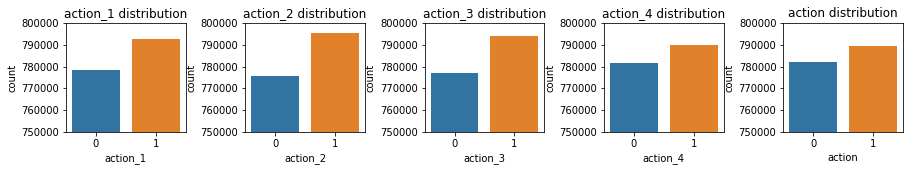

In [7]:
# feature name
features = [c for c in train_df.columns if "feature" in c]
#feature_names = train_df.columns[train_df.columns.str.contains('feature')].to_list()
#features.remove('feature_0')


# create action
resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']
action_cols = []

for resp in resp_cols:
    action = resp.replace('resp', 'action')
    action_cols.append(action)
    train_df[action] = (train_df[resp] * train_df['weight'] > 0).astype(int)
    
plt.figure(figsize=(15, 2))
for i, action in enumerate(action_cols, 1):
    plt.subplot(1, 5, i)
    plt.ylim(7.5e5, 8.0e5)
    sns.countplot(train_df[action])
    
    plt.title(f'{action} distribution')
    plt.subplots_adjust(wspace=0.5)
plt.show()

In [8]:
x_data = train_df[features].values
y_data = train_df[action_cols].values
groups = train_df['date'].values

# PurgedGroupTimeSeriesSplit

In [9]:
# PurgedGroupTimeSeriesSplit
# https://www.kaggle.com/marketneutral/purged-time-series-cv-xgboost-optuna
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose
        
    def __len__(self): 
        return self.n_splits

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [10]:
# plot_cv_indices
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
    
# this is code slightly modified from the sklearn docs here:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [11]:
cv = PurgedGroupTimeSeriesSplit(
    #max_train_group_size=200,
    group_gap=20,
)

144426 237204
372534 263792
621401 270184
889748 282063
1175505 312613


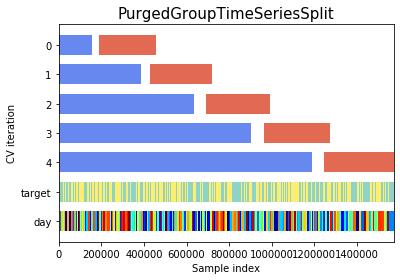

In [12]:
# plot cv
for i, (trn_idx, val_idx) in enumerate(cv.split(x_data, y_data, groups=groups)):
    print(len(trn_idx), len(val_idx))
    
fig, ax = plt.subplots()
plot_cv_indices(cv, x_data, y_data[:, 4], groups, ax, 5, lw=20);

# train cls

In [13]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets: torch.Tensor, n_labels: int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
                                           self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets, self.weight)

        if self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()

        return loss


class MarketDataset(Dataset):
    def __init__(self, x, y):
        self.x = x

        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (torch.tensor(self.x[idx], dtype=torch.float),
                torch.tensor(self.y[idx], dtype=torch.float))


class Mish(nn.Module):
    class MishAutoFn(torch.autograd.Function):
        """Mish: A Self Regularized Non-Monotonic Neural Activation Function - https://arxiv.org/abs/1908.08681
        Experimental memory-efficient variant
        """
        @staticmethod
        def forward(ctx, x):
            ctx.save_for_backward(x)
            y = x.mul(torch.tanh(F.softplus(x)))  # x * tanh(ln(1 + exp(x)))
            return y

        @staticmethod
        def backward(ctx, grad_output):
            x = ctx.saved_tensors[0]
            x_sigmoid = torch.sigmoid(x)
            x_tanh_sp = F.softplus(x).tanh()
            return grad_output.mul(x_tanh_sp + x * x_sigmoid *
                                   (1 - x_tanh_sp * x_tanh_sp))

    def __init__(self, inplace: bool = False):
        super(Mish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return self.MishAutoFn.apply(x)


class Block(nn.Module):
    def __init__(self, in_dim, out_dim, dropout_rate=0.2):
        super(Block, self).__init__()
        self.dense = nn.Linear(in_dim, out_dim)
        self.batch_norm = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.mish = Mish()

    def forward(self, x):
        x1 = self.dense(x)
        x1 = self.mish(x1)
        x1 = self.batch_norm(x1)
        x1 = self.dropout(x1)
        return x, x1


class Model(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_size=256, dropout_rate=0.2):
        super(Model, self).__init__()
        self.batch_norm0 = nn.BatchNorm1d(in_dim)
        self.dropout0 = nn.Dropout(dropout_rate)

        self.block1 = Block(in_dim, hidden_size)

        self.block2 = Block(hidden_size + in_dim, hidden_size)

        self.block3 = Block(hidden_size + hidden_size, hidden_size)

        self.block4 = Block(hidden_size + hidden_size, hidden_size)

        self.dense5 = nn.Linear(hidden_size + hidden_size, out_dim)
        

    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.dropout0(x)

        x, x1 = self.block1(x)
        x = torch.cat([x, x1], 1)

        x, x2 = self.block2(x)
        x = torch.cat([x1, x2], 1)
        
        x, x3 = self.block3(x)
        x = torch.cat([x2, x3], 1)
        
        x, x4 = self.block4(x)
        x = torch.cat([x3, x4], 1)

        x = self.dense5(x)

        return x

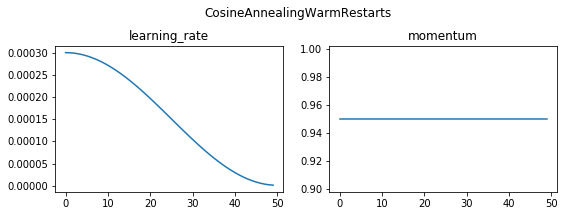

In [14]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.Ranger
#CFG.optimizer = torch.optim.Adam
CFG.optim_param = optim_param

scheduler_param = {
    'T_0': CFG.epochs,
    'T_mult': 1,
    'eta_min': 1e-6,
}
CFG.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts
CFG.scheduler_param = scheduler_param


cfg = CFG
model = nn.Linear(1, 1)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* (len(os.listdir(data_path+'train_images/')) // CFG.bs)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)
    plt.subplots_adjust(top=0.80)
    plt.show()


show_learning_rate_scheduler()

In [15]:
def accuracy(preds, ys):
    preds = (preds>0.5).int()
    return (preds == ys).float().mean()

In [16]:
CFG.metric = accuracy
CFG.criterion = SmoothBCEwLogits(smoothing=CFG.smooth)

In [17]:
import threading
import queue


class MultiThreadWrapper(threading.Thread):
    def __init__(self, generator, max_prefetch=1):
        """
        This function transforms generator into a background-thead generator.
        :param generator: generator or genexp or any
        It can be used with any minibatch generator.
        It is quite lightweight, but not entirely weightless.
        Using global variables inside generator is not recommended (may rise GIL and zero-out the benefit of having a background thread.)
        The ideal use case is when everything it requires is store inside it and everything it outputs is passed through queue.
        There's no restriction on doing weird stuff, reading/writing files, retrieving URLs [or whatever] wlilst iterating.
        :param max_prefetch: defines, how many iterations (at most) can background generator keep stored at any moment of time.
        Whenever there's already max_prefetch batches stored in queue, the background process will halt until one of these batches is dequeued.
        !Default max_prefetch=1 is okay unless you deal with some weird file IO in your generator!
        Setting max_prefetch to -1 lets it store as many batches as it can, which will work slightly (if any) faster, but will require storing
        all batches in memory. If you use infinite generator with max_prefetch=-1, it will exceed the RAM size unless dequeued quickly enough.
        """
        threading.Thread.__init__(self)
        self.queue = queue.Queue(max_prefetch)
        self.generator = generator
        self.daemon = True
        self.start()
        self.exhausted = False

    def run(self):
        for item in self.generator:
            self.queue.put(item)
        self.queue.put(None)

    def __len__(self):
        return len(self.generator)

    def __next__(self):
        if self.exhausted:
            raise StopIteration
        else:
            next_item = self.queue.get()
            if next_item is None:
                raise StopIteration
            return next_item

    def __iter__(self):
        return self

In [18]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



class EearlyStop:
    def __init__(self, patience=4, min_delta=0.005, mode='min'):
        '''
        mode: {min, max}
        '''
        self.record = np.inf if mode == 'min' else -np.inf
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.wait = 0
        
    def cal_improve(self, val_loss: float) -> bool:
        esp = 1e-8
        ratio = (val_loss - self.record + esp) / (self.record + esp)
        if ratio > 0:
            improve = False
        else:
            improve = True if -ratio > self.min_delta else False
        return improve
    
    def stop(self, val_loss: float) -> bool:
        # improve = self.cal_improve(val_loss)
        improve = True if val_loss < self.record else False
        if self.mode == 'max': improve = not improve
        
        if improve: 
            self.wait = 0
            self.record = val_loss            
        else: self.wait += 1

        
        if self.wait > self.patience: return True
        else: return False

In [19]:
class Learner():
    def __init__(self, cfg, model):
        self.cfg = cfg

        self.criterion = cfg.criterion
        self.metric = cfg.metric
        self.scaler = torch.cuda.amp.GradScaler()

        # recorder
        self.best_loss = np.inf
        self.best_score = 0
        self.epoch = 0
        self.history = {
            'losses': [],
            'trn_losses': [],
            'trn_metrics': [],
            'val_losses': [],
            'val_metrics': [],
            'lrs': [],
        }
        self.mb = master_bar(range(1, cfg.epochs + 1))
        self.mb.write(('epoch', 'train loss', 'train metric', 'val loss',
                       'val metric', 'time'),
                      table=True)
        self.early_stop = EearlyStop(patience=CFG.patience, min_delta=0.05, mode='max')

        # model
        self.device = cfg.device
        self.model = model.to(cfg.device)
        self.optimizer = cfg.optimizer(self.model.parameters(), **cfg.optim_param)
        self.scheduler = cfg.scheduler(self.optimizer, **cfg.scheduler_param)

    def trn_fn(self, trn_loader):
        self.model.train()
        running_loss = AverageMeter()
        running_metric = AverageMeter()
        
        if cfg.worker == 0 and os.name == 'nt':
            trn_loader = MultiThreadWrapper(trn_loader, cfg.max_prefetch)        
        
        trn_tqdm = progress_bar(trn_loader,
                                total=int(len(trn_loader)),
                                parent=self.mb)
        for i, (xs, ys) in enumerate(trn_tqdm):
            batch_size = len(xs)
            xs = xs.to(self.device)
            ys = ys.to(self.device)

            # forward, backward
            with torch.cuda.amp.autocast():
                preds = self.model(xs)
                loss = self.criterion(preds, ys).mean()
                loss_item = loss.item()
                running_loss.update(loss_item, batch_size)
            
            # backward
            loss = loss / self.cfg.iters_to_accumulate
            self.scaler.scale(loss).backward()
            #loss.backward()
            
            # gradient accumulate
            if (i + 1) % self.cfg.iters_to_accumulate == 0:
                # clip grad
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(),
                                                self.cfg.max_grad_norm)
                # step
                self.scaler.step(self.optimizer)
                self.scaler.update()
                #self.optimizer.step()
                self.optimizer.zero_grad()
            
            # step scheduler if lr scheduler is onecycle
            if self.scheduler.__class__.__name__ == 'OneCycleLR':
                self.history['lrs'].append(self.scheduler.optimizer.param_groups[0]['lr'])
                self.scheduler.step()
                
            # metric
            metric = self.metric(preds, ys)
            running_metric.update(metric, batch_size)
            
            # set commet on child progressbar
            self.mb.child.comment = (f'loss={loss_item:.4f}, '
                                     f'metric={metric:.4f}')

        # step scheduler if lr scheduler is not onecycle
        if self.scheduler.__class__.__name__ != 'OneCycleLR':
            self.history['lrs'].append(self.scheduler.optimizer.param_groups[0]['lr'])
            self.scheduler.step()
        return running_loss.avg, running_metric.avg

    def val_fn(self, val_loader):
        self.model.eval()
        running_loss = AverageMeter()
        running_metric = AverageMeter()
        val_preds = []
        
        if cfg.worker == 0 and os.name == 'nt':
            val_loader = MultiThreadWrapper(val_loader, cfg.max_prefetch//4)

        val_tqdm = progress_bar(val_loader,
                                total=int(len(val_loader)),
                                parent=self.mb)
        for i, (xs, ys) in enumerate(val_tqdm):
            batch_size = len(xs)
            xs = xs.to(self.device)
            ys = ys.to(self.device)

            self.model.eval()
            with torch.cuda.amp.autocast():
                with torch.no_grad():
                    preds = self.model(xs)
                    loss = self.criterion(preds, ys).mean()
                    metric = self.metric(preds, ys)
                    
            # record
            running_loss.update(loss.item(), batch_size)
            running_metric.update(metric, batch_size)
            val_preds.append(preds.detach().cpu().numpy())

            # set commet on child progressbar
            self.mb.child.comment = (f'val_loss={loss.item():.4f}, '
                                     f'val_metric={metric:.4f}')

        val_preds = np.concatenate(val_preds)
        return running_loss.avg, running_metric.avg, val_preds

    def plot_history(self, fold_num=0):
        fig = plt.figure(figsize=(16, 3))
        fig.subplots_adjust(top=0.8)
        plt.suptitle(f'fold{fold_num}')

        # metrics
        plt.subplot(131)
        #plt.ylim(0.01, 0.03)
        plt.plot(self.history['trn_metrics'], 'C0', label='train')
        plt.plot(self.history['val_metrics'], 'C1', label='val')
        plt.title(f'Metric')
        plt.legend()
        plt.ylabel("Metric")
        plt.xlabel("Epoch")

        # loss
        plt.subplot(132)
        #plt.ylim(0.01, 0.03)
        plt.plot(self.history['trn_losses'], 'C0', label='train')
        plt.plot(self.history['val_losses'], 'C1', label='val')
        plt.title(f'Loss')
        plt.legend()
        plt.ylabel("Loss")
        plt.xlabel("Epoch")

        # lr
        plt.subplot(133)
        plt.plot(self.history['lrs'][1:], 'C0', label='lr')
        plt.title(f'Learning rate')
        plt.ylabel("lr")
        if self.history['lrs'][0] == 'OneCycleLR':
            plt.xlabel("Iteration")
        else:
            plt.xlabel("Epoch")

        plt.show()

    def fit_single(
        self,
        #train_df,
        fold_idx,
        trn_loader,
        val_loader,
        fold_num=0,
    ):
        # recorder
        self.history = {
            'losses': [],
            'trn_losses': [],
            'trn_metrics': [],
            'val_losses': [],
            'val_metrics': [],
            'lrs': [],
        }
        self.history['lrs'].append(self.scheduler.__class__.__name__)
        trn_idx, val_idx = fold_idx

        # train & validate
        for epoch in self.mb:            
            self.epoch = epoch
            start_time = time.time()
            trn_loss, trn_metric = self.trn_fn(trn_loader)
            val_loss, val_metric, val_preds = self.val_fn(val_loader)

            # checkpoint
            #if val_loss < self.best_loss:
            if val_metric > self.best_score:
                logger.info(f'epoch{epoch} save best model... {val_metric}')
                #self.best_loss = val_loss
                self.best_score = val_metric
                
                #oof = np.zeros((len(train_df), train_df.label.nunique()))
                #oof[val_idx] = val_preds
                save_name = f"fold_{fold_num}.pth"
                self.save(save_name)
                
            # calculate time
            end_time = time.time()
            m, s = divmod(end_time - start_time, 60)

            # record
            self.history['trn_losses'].append(trn_loss)
            self.history['trn_metrics'].append(trn_metric)
            self.history['val_losses'].append(val_loss)
            self.history['val_metrics'].append(val_metric)
            self.mb.write(
                (f'{epoch}', 
                 f'{trn_loss:.6f}', 
                 f'{trn_metric:.6f}',
                 f'{val_loss:.6f}', 
                 f'{val_metric:.6f}', 
                 f'{m:.0f}:{s:.0f}'),
                table=True)
            
            # early stop
            break_flag = self.early_stop.stop(val_metric)
            if break_flag:
                logger.info(f"early stop...")
                break
                
        # record cv score
        #score = self.metric(oof[val_idx], train_df.iloc[val_idx]['label'].values)
        #logger.info(f"fold{fold_num} score: {score}")
        self.plot_history(fold_num)

        # del
        torch.cuda.empty_cache()

        #return oof
    
    def save(self, path):
        self.model.eval()
        torch.save({
            #'model_state_dict': self.model.model.state_dict(),
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'scaler': self.scaler.state_dict(),
            'best_loss': self.best_loss,
            'epoch': self.epoch,
            'history': self.history,   
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.scaler.load_state_dict(checkpoint['scaler'])
        self.best_loss = checkpoint['best_loss']
        self.epoch = checkpoint['epoch']
        self.history = checkpoint['history']

In [20]:
def run_kfold(cfg, x_data, y_data, n_fold=5, aug=None, pre_load=False):

    #oof = np.zeros((len(x_data), y_data.shape[1])

    folds = PurgedGroupTimeSeriesSplit(
        n_splits=n_fold,
        group_gap=20,
        max_train_group_size=200,
        )
    for fold_num, (fold_idx) in enumerate(folds.split(x_data,  y_data, groups=groups)):
        logger.info(f'fold {fold_num}')
        trn_idx, val_idx = fold_idx

        trn_ds = MarketDataset(x_data[trn_idx], y_data[trn_idx])
        val_ds = MarketDataset(x_data[val_idx], y_data[val_idx])

        trn_dl = DataLoader(
            trn_ds,
            batch_size=CFG.bs,
            shuffle=True,
            drop_last=False,
            num_workers=cfg.worker,
        )
        val_dl = DataLoader(
            val_ds,
            batch_size=CFG.bs,
            drop_last=False,
            num_workers=cfg.worker,
        )

        model = Model(x_data.shape[1], y_data.shape[1])
        learner = Learner(CFG, model)
        learner.fit_single(fold_idx, trn_dl, val_dl, fold_num)           
        #_oof = learner.fit_single(train_df, fold_idx, trn_dl, val_dl, fold_num)
        #oof += _oof
    #score = compute_metric(oof, train_df.label.values)
    #logger.info(f"CV score: {score}")
    del trn_ds, val_ds

    #return oof, learner

fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.727293,0.496908,0.696435,0.496243,0:12
2,0.712571,0.498135,0.693724,0.496578,0:10
3,0.706492,0.498319,0.692630,0.496954,0:11
4,0.702161,0.499301,0.691937,0.496707,0:10
5,0.699751,0.499182,0.691566,0.497446,0:10
6,0.697695,0.499758,0.691422,0.496973,0:10
7,0.695892,0.500151,0.691607,0.497518,0:10
8,0.694819,0.500042,0.691502,0.497605,0:11
9,0.693844,0.500306,0.691268,0.497260,0:12
10,0.693131,0.500460,0.691219,0.498132,0:12


C:\Users\user\anaconda3\lib\site-packages\pytorch_ranger\ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
epoch1 save best model... 0.4962429702281952
epoch2 save best model... 0.496577650308609
epoch3 save best model... 0.4969538450241089
epoch5 save best model... 0.4974459409713745
epoch7 save best model... 0.4975176453590393
epoch8 save best model... 0.49760451912879944
epoch10 save best model... 0.4981323182582855
epoch13 save best model... 0.49823448061943054
epoch15 save best model... 0.49856826663017273
epoch20 save best model... 0.49892985820770264
epoch24 save best model... 0.49914073944091797
early stop...


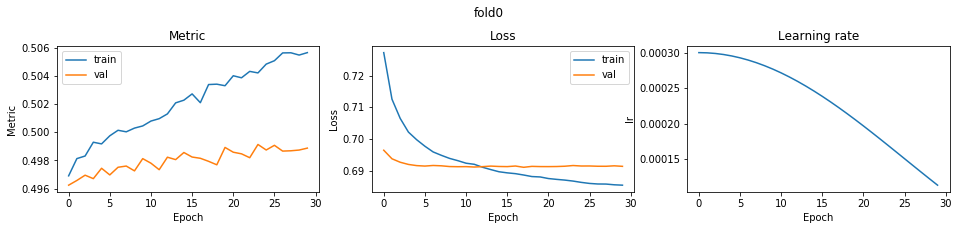

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.715566,0.497854,0.691967,0.498857,0:23
2,0.702294,0.499022,0.690771,0.499064,0:21
3,0.697691,0.499112,0.690409,0.498832,0:20
4,0.695423,0.499061,0.690163,0.498505,0:20
5,0.694009,0.498921,0.690135,0.499689,0:19
6,0.692534,0.499616,0.690086,0.499615,0:19
7,0.691787,0.499739,0.690226,0.499278,0:19
8,0.691135,0.499490,0.690321,0.500574,0:20
9,0.690325,0.500184,0.690071,0.499335,0:19
10,0.689918,0.500210,0.690055,0.500591,0:19


epoch1 save best model... 0.49885663390159607
epoch2 save best model... 0.49906447529792786
epoch5 save best model... 0.49968916177749634
epoch8 save best model... 0.5005739331245422
epoch10 save best model... 0.5005913972854614
epoch11 save best model... 0.5006694197654724
epoch13 save best model... 0.5006967186927795
epoch14 save best model... 0.5010660290718079
epoch17 save best model... 0.5010955929756165
epoch22 save best model... 0.501173734664917
epoch23 save best model... 0.5017552375793457
epoch25 save best model... 0.5019925236701965
epoch27 save best model... 0.5022213459014893
epoch29 save best model... 0.5024276971817017
early stop...


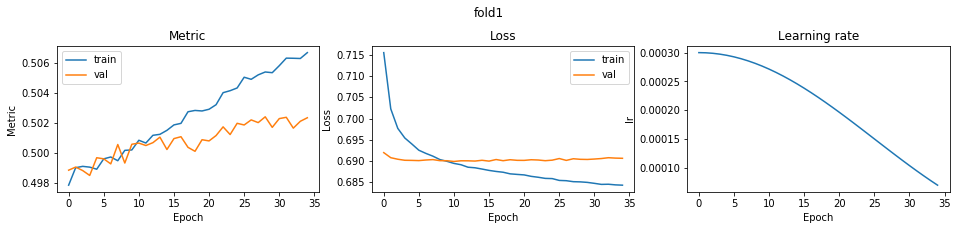

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.711185,0.499468,0.691086,0.497756,0:27
2,0.698040,0.500325,0.690546,0.498648,0:27
3,0.694515,0.499944,0.690221,0.498479,0:26
4,0.692729,0.499905,0.689902,0.498818,0:27
5,0.691588,0.499927,0.689850,0.498873,0:28
6,0.690679,0.500355,0.689735,0.498764,0:27
7,0.690149,0.500519,0.689636,0.499293,0:27
8,0.689509,0.500915,0.689654,0.498937,0:26
9,0.689159,0.501099,0.689754,0.498949,0:26
10,0.688800,0.501396,0.689480,0.500073,0:25


epoch1 save best model... 0.4977564513683319
epoch2 save best model... 0.4986483156681061
epoch4 save best model... 0.49881845712661743
epoch5 save best model... 0.49887263774871826
epoch7 save best model... 0.49929317831993103
epoch10 save best model... 0.500073254108429
epoch12 save best model... 0.5003848075866699
epoch13 save best model... 0.5008659958839417
early stop...


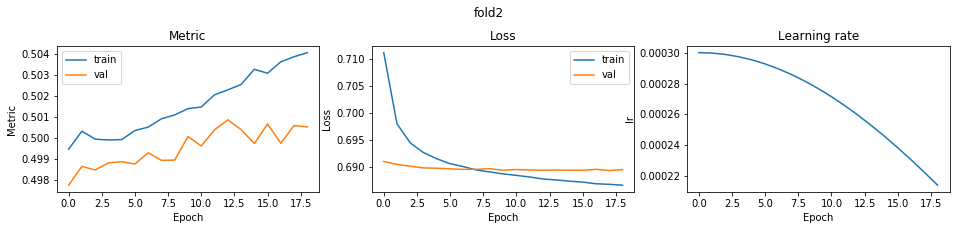

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.710684,0.500318,0.691669,0.502047,0:30
2,0.697485,0.500599,0.691549,0.502681,0:30
3,0.694018,0.500696,0.690952,0.502484,0:31
4,0.692320,0.500782,0.690861,0.503584,0:31
5,0.691286,0.500653,0.690714,0.503235,0:32
6,0.690541,0.501104,0.690846,0.502625,0:30
7,0.689965,0.501158,0.690691,0.504132,0:30
8,0.689544,0.501335,0.690709,0.504542,0:31
9,0.689213,0.501535,0.690704,0.503506,0:32
10,0.688854,0.501792,0.690789,0.504483,0:30


epoch1 save best model... 0.5020473599433899
epoch2 save best model... 0.502681314945221
epoch4 save best model... 0.5035838484764099
epoch7 save best model... 0.5041320323944092
epoch8 save best model... 0.5045418739318848
epoch12 save best model... 0.5048027634620667
epoch13 save best model... 0.5048744678497314
epoch18 save best model... 0.5051743984222412
epoch19 save best model... 0.5052672624588013
epoch21 save best model... 0.505304753780365
epoch22 save best model... 0.5060251355171204
epoch26 save best model... 0.5064104199409485
early stop...


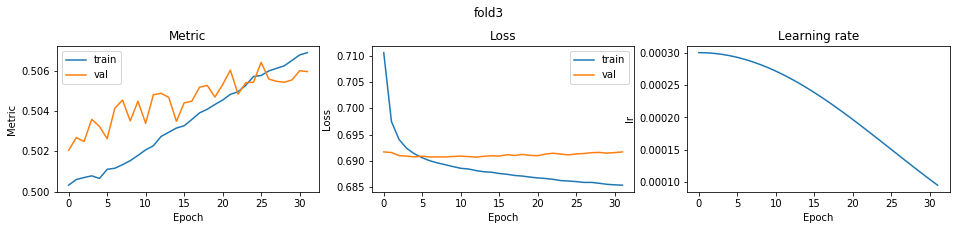

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.709891,0.501576,0.690527,0.499663,0:32
2,0.697105,0.501264,0.689816,0.501060,0:33
3,0.693836,0.501195,0.689309,0.501311,0:33
4,0.692299,0.501178,0.689342,0.501542,0:32
5,0.691323,0.501420,0.689136,0.501171,0:32
6,0.690649,0.501386,0.688738,0.502443,0:33
7,0.690196,0.501451,0.688706,0.501678,0:32
8,0.689828,0.501562,0.688521,0.502858,0:32
9,0.689467,0.501670,0.688457,0.503101,0:32
10,0.689246,0.502006,0.688485,0.502827,0:31


epoch1 save best model... 0.49966302514076233
epoch2 save best model... 0.5010597109794617
epoch3 save best model... 0.5013105869293213
epoch4 save best model... 0.5015420913696289
epoch6 save best model... 0.5024429559707642
epoch8 save best model... 0.5028581023216248
epoch9 save best model... 0.5031006932258606
epoch11 save best model... 0.5038574934005737
epoch15 save best model... 0.5038807392120361
epoch16 save best model... 0.5047006011009216
epoch20 save best model... 0.5061692595481873
early stop...


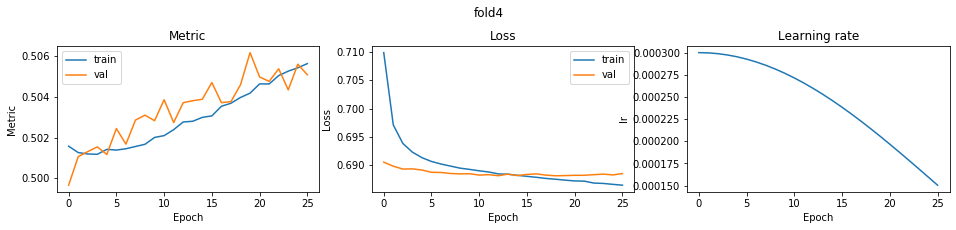

In [21]:
run_kfold(CFG, x_data, y_data, n_fold=5)